# Mount to drive

# Data

In [86]:
import pandas as pd
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

In [87]:
df = pd.read_csv("product_images.csv")
data = df.to_numpy()

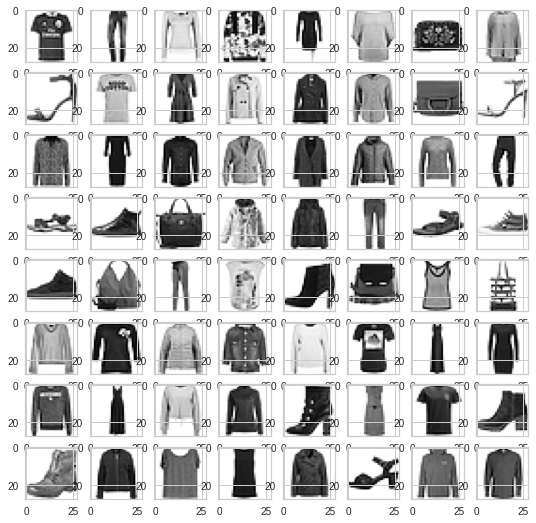

In [88]:
plt.figure(figsize = (10,9))

bottom = 0.2

for i in range(64):
  plt.subplots_adjust(bottom)
  plt.subplot(8,8,i+1)
  plt.imshow(np.reshape(data[:64], (64,28,28))[i])

# Utility Functions

In [89]:
import random

In [90]:
def show_group(group, g):
  plt.figure(figsize=(10,10))
  for i, v in enumerate(random.sample(group[g], 36)):
    plt.subplots_adjust(0.2)
    plt.subplot(6,6,i+1)
    plt.imshow(np.reshape(data, (10000, 28,28))[v])

In [91]:
def group_by_clusters(labels):
  map = {}

  for i in range(len(set(labels))):
    map[i]=[ k for k,v in enumerate(labels) if v == i]
  
  return map

In [92]:
def display_img(pixels):
  plt.figure(figsize=(1,1))
  plt.imshow(np.reshape(pixels, (28,28)))

In [93]:
def normalise_img(img):
  return(img-min(img))/(max(img)-min(img)) 

# Preprocessing

In [94]:
random_state=999

In [95]:
from skimage import exposure
from sklearn import preprocessing

In [96]:
# Conversion to float
X = data.astype('float64') 

# Normalise
X = X/255.0

# Equaliee exposure
X = np.array([exposure.equalize_hist(each) for each in X])

# # Normalise
X = np.array([normalise_img(each) for each in X])

# Reshaping input data
X = X.reshape(len(data),-1)


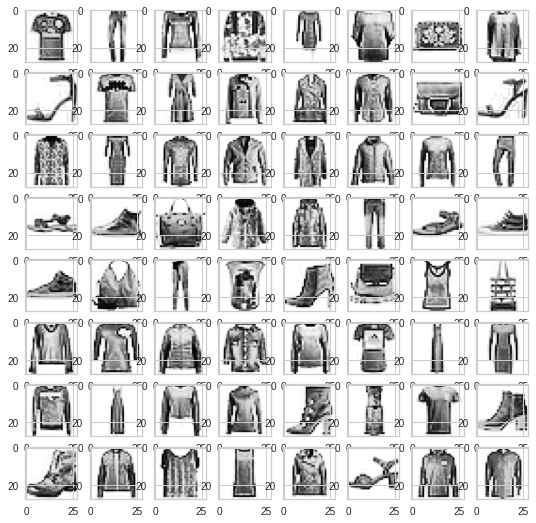

In [97]:
# display preprocessed data
plt.figure(figsize = (10,9))

bottom = 0.2

for i in range(64):
  plt.subplots_adjust(bottom)
  plt.subplot(8,8,i+1)
  plt.imshow(np.reshape(X[:64], (64,28,28))[i])

In [98]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

## PCA



In [99]:
from sklearn.decomposition import PCA

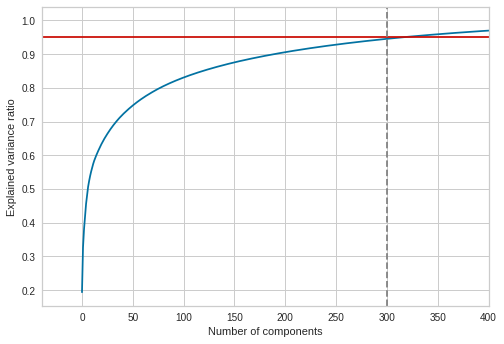

In [100]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.xlim(right=400)
plt.ylabel('Explained variance ratio')
plt.axhline(0.95, color = 'r', linestyle = '-')
plt.axvline(x=300, color='gray', linestyle='--')
plt.show()

In [101]:
pca = PCA(n_components = 300)
pca.fit(X)
X_pca = pca.transform(X)

## t-SNE

From above, best perplexity=40, best n_iter=1750

In [102]:
from sklearn import manifold
import numpy as np

In [103]:
# Perform feature extraction using t-SNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=40, 
                     n_iter=1750)
X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [104]:
# Print the shape of the new feature spaces
print("t-SNE feature space shape:", X_tsne.shape)

t-SNE feature space shape: (10000, 2)


# Choosing feature extraction method

In [105]:
total_clusters = 10

In [106]:
scores = {}

In [127]:
def get_silelbow(X, total_clusters):
  kmeans = MiniBatchKMeans(n_clusters = total_clusters, random_state=random_state)
  kmeans.fit(X)
  # Import the KElbowVisualizer method 
  visualiser = KElbowVisualizer(kmeans, k=(2,14), metric='silhouette', timings=False)
  # Fit the data and visualize
  visualiser.fit(X)    
  visualiser.poof()

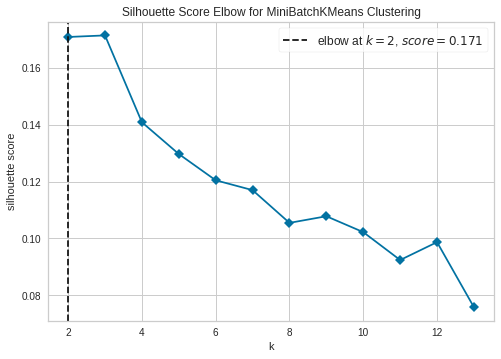

In [128]:
get_silelbow(X, total_clusters)

In [129]:
# choose 
n = 7
kmeans = MiniBatchKMeans(n_clusters = n, random_state=random_state)
kmeans.fit(X)
scores["all_features"] = silhouette_score(X, kmeans.labels_)

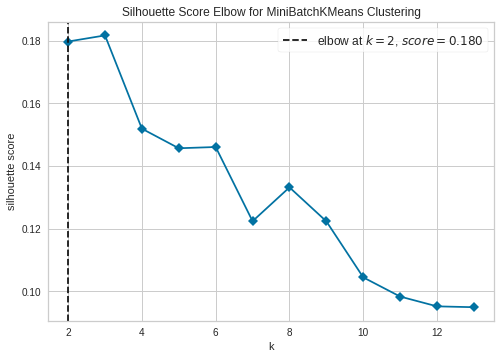

In [130]:
get_silelbow(X_pca, total_clusters)

In [131]:
# choose 
n = 8
kmeans = MiniBatchKMeans(n_clusters = n, random_state=random_state)
kmeans.fit(X_pca)
scores["pca"] = silhouette_score(X_pca, kmeans.labels_)

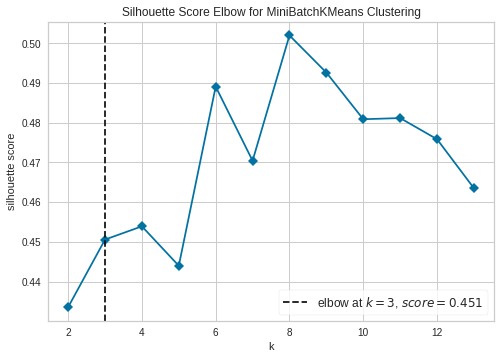

In [132]:
get_silelbow(X_tsne, total_clusters)

In [133]:
# choose 
n = 8
kmeans = MiniBatchKMeans(n_clusters = n, random_state=random_state)
kmeans.fit(X_tsne)
scores["tsne"] = silhouette_score(X_tsne, kmeans.labels_)

In [114]:
scores

{'all_features': 0.11699956812343355,
 'pca': 0.13317265159949435,
 'tsne': 0.50194085}

 Best feature extraction method is t-SNE

# Choosing k

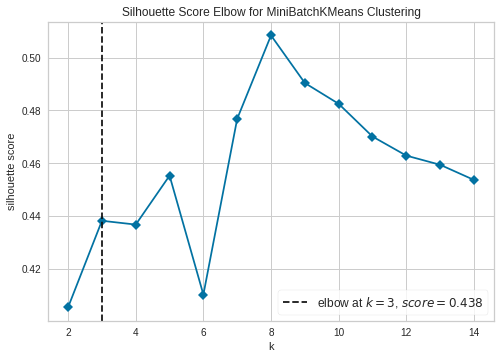

Optimal Silhouette Score at k=8

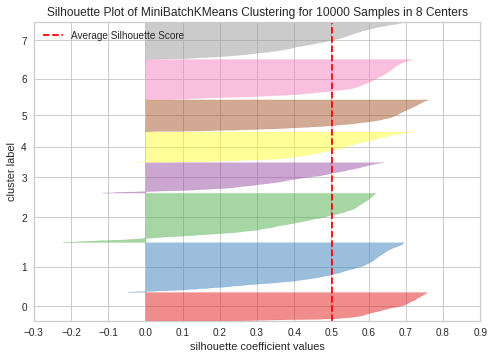

In [115]:
SilhouetteVisualizer(MiniBatchKMeans(n_clusters=8, random_state=random_state)).fit(X_tsne).show()

# Build final model

In [116]:
kmeans = MiniBatchKMeans(n_clusters = 8, init="k-means++", n_init=3, random_state=999)
kmeans.fit(X_tsne)

MiniBatchKMeans(random_state=999)

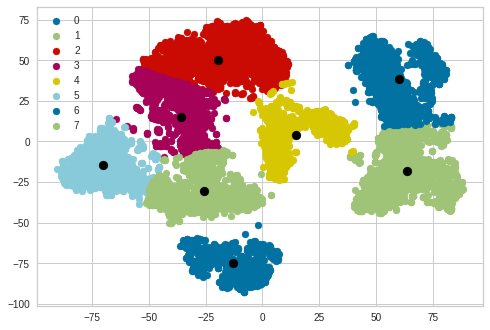

In [117]:
x_vals = [each[0] for each in X_tsne]
y_vals = [each[1] for each in X_tsne]
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

for k in np.unique(kmeans.labels_):
    x_vals = [X_tsne[i][0] for i in range(len(X_tsne)) if labels[i]==k]
    y_vals = [X_tsne[i][1] for i in range(len(X_tsne)) if labels[i]==k]
    plt.scatter(x_vals , y_vals, label = k)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()

In [118]:
group = group_by_clusters(kmeans.labels_)

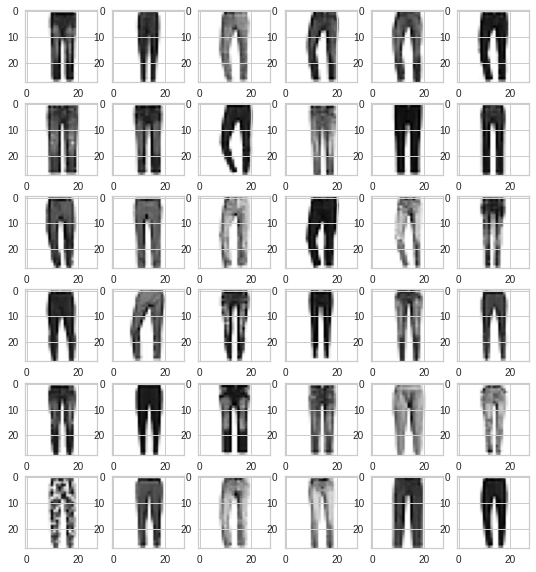

In [119]:
show_group(group, 0) 

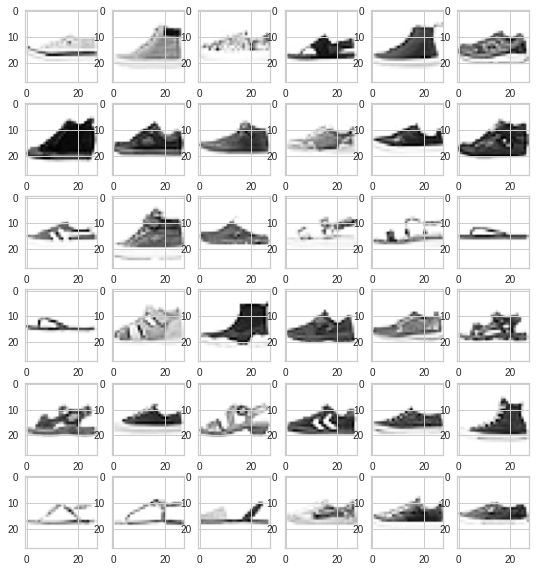

In [120]:
show_group(group, 1) 

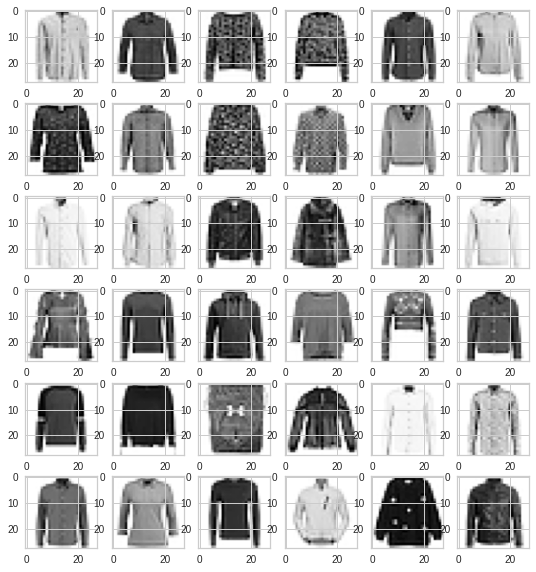

In [121]:
show_group(group, 2) 

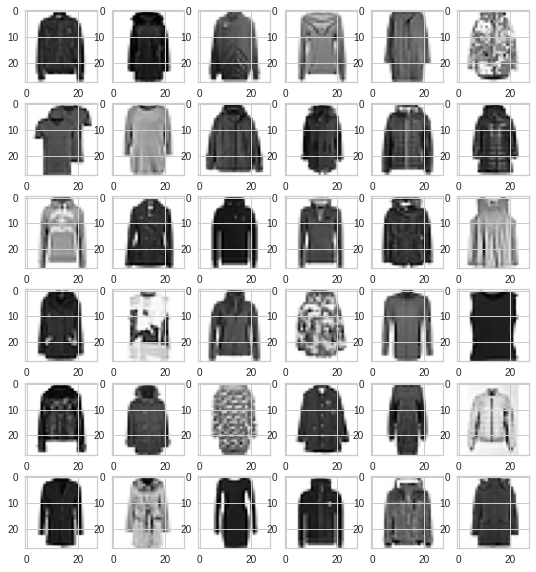

In [122]:
show_group(group, 3) 

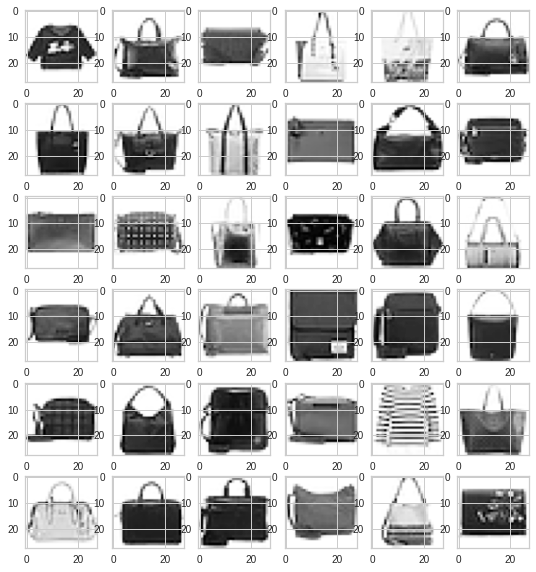

In [123]:
show_group(group, 4) 

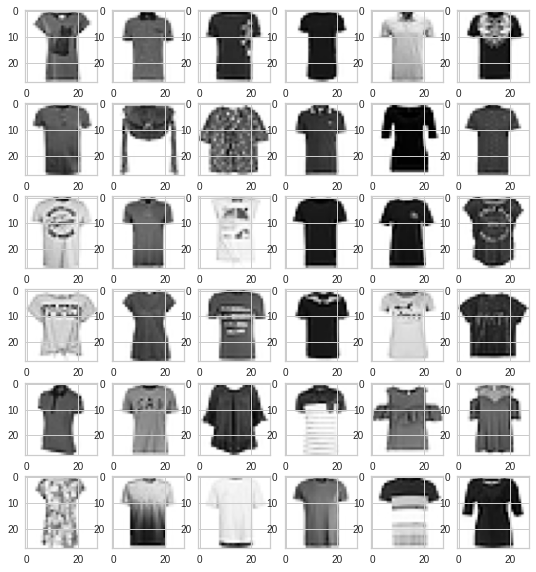

In [124]:
show_group(group, 5) 

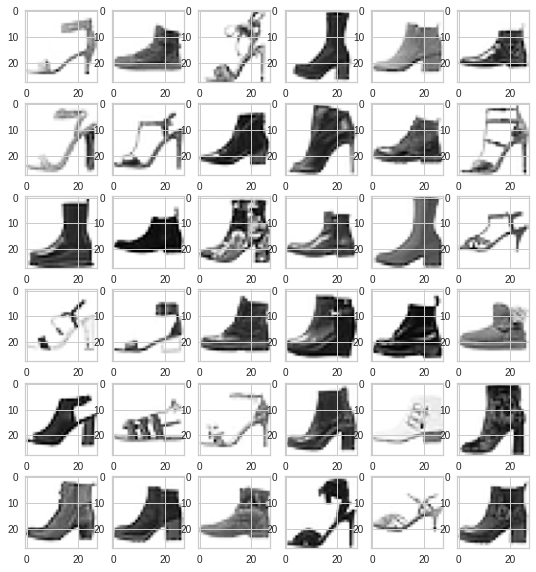

In [125]:
show_group(group, 6) 

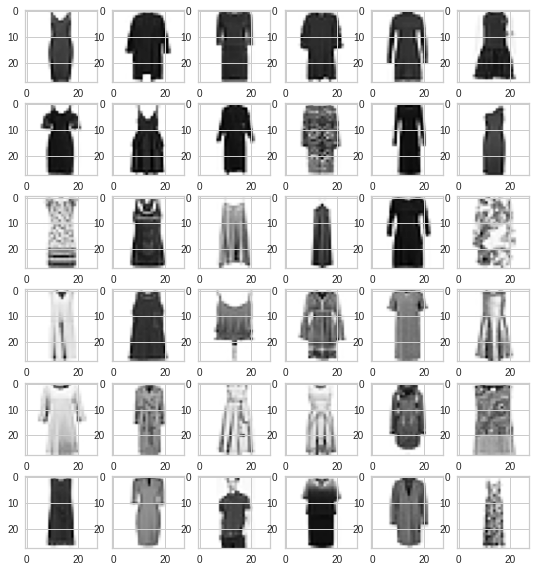

In [126]:
show_group(group, 7) 

# Saving model outputs

In [134]:
from numpy import save
from numpy import load

In [131]:
save('X_tsne.npy', X_tsne)

'X_tsne)' was not found in history, as a file, url, nor in the user namespace.


In [132]:
save('labels.npy', kmeans.labels_)

'kmeans.labels_)' was not found in history, as a file, url, nor in the user namespace.


In [133]:
save('centres.npy', kmeans.cluster_centers_)

'kmeans.cluster_centers_)' was not found in history, as a file, url, nor in the user namespace.


In [156]:
save('X.npy', X)

In [136]:
save('X_pca.npy', X_pca)